# Part 3 - Predictive Modeling

___


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme(style="darkgrid")
import datetime as dt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


___

## 1 Data Exploration and Cleaning

In [4]:
# loading our json file into a dataframe
df = pd.read_json('ultimate_data_challenge.json')

In [5]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


___

### 1.1 Converting Dates to DateTime Objects

In [8]:
# converting 'signup_date' and 'last_trip_date' to dateTime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

___

### 1.2 Handeling Missing Values

In [11]:
# defining a function to check missing values by column 
def percentageOfnull(df):
    nan_count = df.isna().sum().sort_values(ascending=False)
    nan_percentage = ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False)
    train_test_dtype = df.dtypes
    df_info = pd.concat([nan_count,nan_percentage,train_test_dtype],axis=1,keys=['Null Count','Null Percentage %','DataTypes'])
    return df_info[df_info['Null Count']>0]

In [12]:
# columns with missing values:
percentageOfnull(df)

,Null Count,Null Percentage %,DataTypes
avg_rating_of_driver,8122,16.244,float64
phone,396,0.792,object
avg_rating_by_driver,201,0.402,float64


The percentages of missing values is not alarming. Now, we will handle the missing values. Let's start with the 'phone' column:

#### 1.2.1 'phone' Column:

In [14]:
df['phone'].value_counts()

phone
iPhone     34582
Android    15022
Name: count, dtype: int64

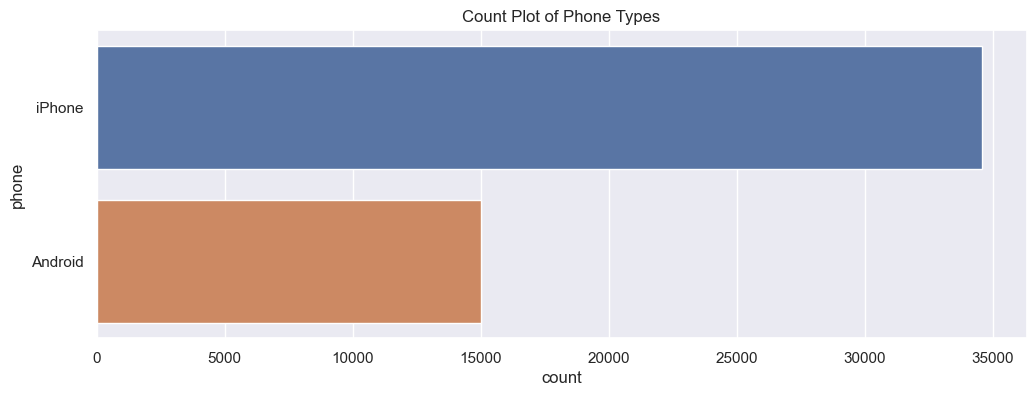

In [15]:
plt.figure(figsize = (12,4))
plt.title('Count Plot of Phone Types')
sns.countplot(y = 'phone', data = df);

Since the number of missing values in this column is low, and for the sake of not losing any information, we will label the missing values as 'unknown':

In [17]:
df['phone'] = df['phone'].fillna(value = 'unknown')

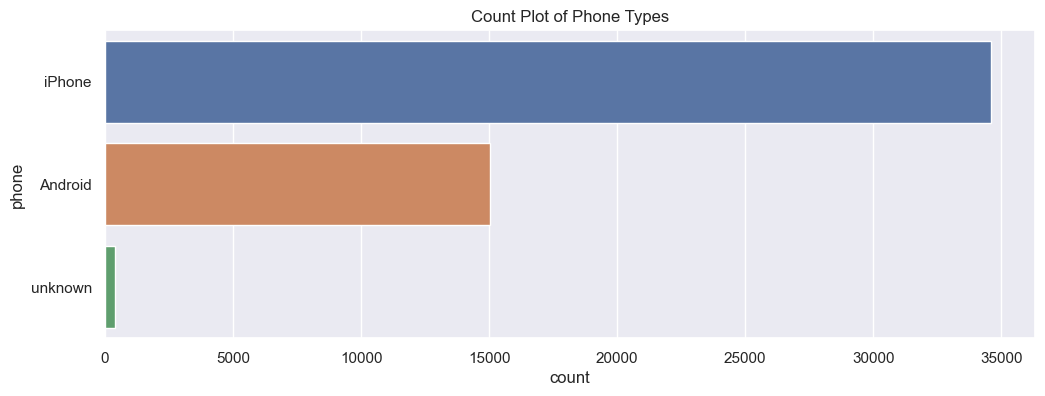

In [18]:
plt.figure(figsize = (12,4))
plt.title('Count Plot of Phone Types')
sns.countplot(y = 'phone', data = df);

#### 1.2.2 'avg_rating_by_driver' Column:

In [20]:
# the mean of 'avg_rating_by_driver' is: (.mean() excludes missing values automatically)
df['avg_rating_by_driver'].mean()

4.77815819594771

In [21]:
# the median of 'avg_rating_by_driver' is: (.median() excludes missing values automatically)
df['avg_rating_by_driver'].median()

5.0

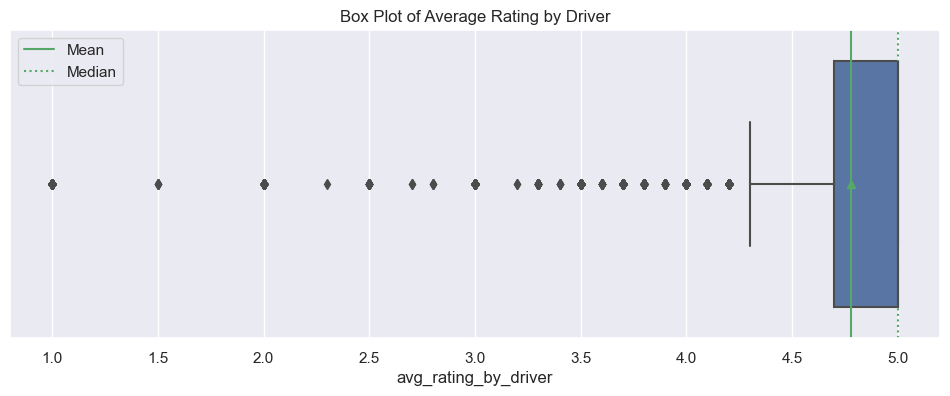

In [22]:
# boxplot of the distribution of 'avg_rating_by_driver', with the mean and median showing on the plot:
plt.figure(figsize = (12,4))
plt.axvline(x = 4.77815, label = 'Mean', color = 'g')
plt.axvline(x = 5, label = 'Median', color = 'g', linestyle = 'dotted')
plt.legend()
plt.title('Box Plot of Average Rating by Driver')
sns.boxplot(x = df['avg_rating_by_driver'], data = df, showmeans = True);

Since the difference between the mean and the median is small, using either of these two values to fill the missing values seems reasonable here. But, since using the median would assume that the rider left the highest rating available, we will use the mean instead since it is more conservative in estimating the rider's satisfaction with the ride.

In [24]:
# using the mean to fill missing values
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value = df['avg_rating_by_driver'].mean() )

In [25]:
# checking if there are any missing values left
df['avg_rating_by_driver'].isna().sum()

0

#### 1.2.3 'avg_rating_of_driver' Column

In [27]:
# the mean of 'avg_rating_by_driver' is: (.mean() excludes missing values automatically)
df['avg_rating_of_driver'].mean()

4.601559291274655

In [28]:
# the median of 'avg_rating_by_driver' is: (.median() excludes missing values automatically)
df['avg_rating_of_driver'].median()

4.9

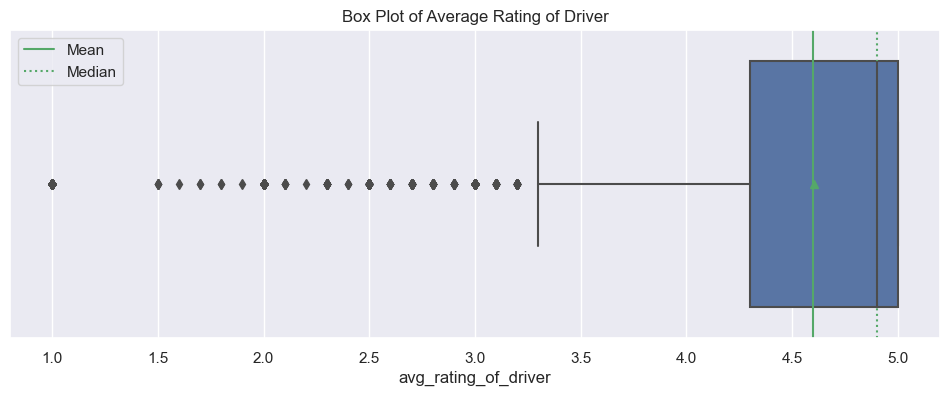

In [29]:
# boxplot of the distribution of 'avg_rating_by_driver', with the mean and median showing on the plot:
plt.figure(figsize = (12,4))
plt.axvline(x = 4.6, label = 'Mean', color = 'g')
plt.axvline(x = 4.9, label = 'Median', color = 'g', linestyle = 'dotted')
plt.legend()
plt.title('Box Plot of Average Rating of Driver')
sns.boxplot(x = df['avg_rating_of_driver'], data = df, showmeans = True);

Again, since the two values are close to each other it makes since to use either of them. We will use the mean to stay consistent.

In [31]:
# using the mean to fill missing values
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value = df['avg_rating_of_driver'].mean() )

In [32]:
# checking if there are any missing values left
df['avg_rating_of_driver'].isna().sum()

0

#### Final Check

In [34]:
# columns with missing values:
percentageOfnull(df)

,Null Count,Null Percentage %,DataTypes


___

### 1.3 Adding a Column for the Target Value 

Our target value is the status of the user, whether they're active or not.</br>
</br>
The definition of an active user is given in the documentation as: "A user is considered active if they took a trip in the preceding 30 days." </br>
</br>
We know that the user accounts in our dataset all signed up in January. But, we were not given a clear date for when this data was pulled up, we need this date in order to be able to determine whether a user is active or not. </br>
</br>
Since we don't have the date the data was pulled, we will assume that the latest available date of 'last_trip_date' column is the date the data were pulled

In [36]:
# we're using the latest 'last_trip_date' as our current date
current_date = df['last_trip_date'].max()
current_date

Timestamp('2014-07-01 00:00:00')

In [37]:
# if the customer had a trip within the last 30 days they're considered active
df['active'] = df['last_trip_date'].apply(lambda x : 1 if ((current_date - x) < dt.timedelta(31)) else 0 )

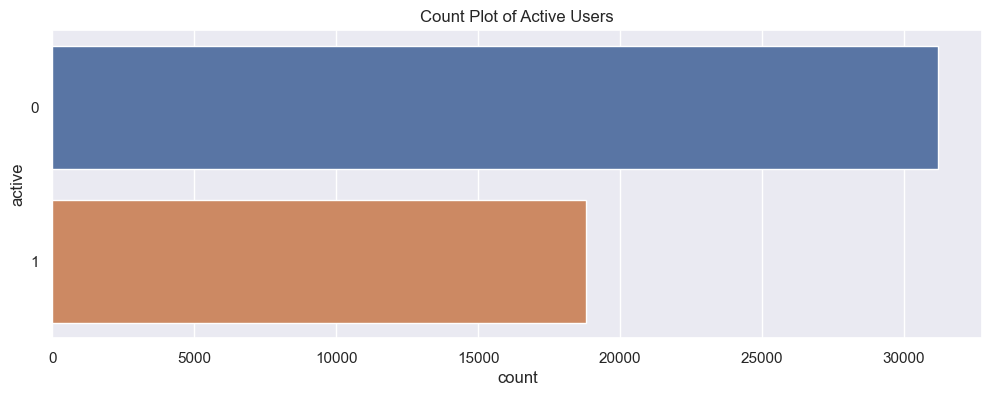

In [38]:
plt.figure(figsize = (12,4))
plt.title('Count Plot of Active Users')
sns.countplot(y = df['active'], data = df);

___ 

### 1.4 Adding Dummy Variables
Now, we need to trun the categorical variables into dummy variables in oreder to use them in modeling.

In [40]:
df_dummies = pd.get_dummies(df, columns=['phone','city'], dtype=int)

In [41]:
df_dummies.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,phone_Android,phone_iPhone,phone_unknown,city_Astapor,city_King's Landing,city_Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,0,1,0,1,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,1,0,0,0,0,1


In [42]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    50000 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  bool          
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    50000 non-null  float64       
 10  active                  50000 non-null  int64         
 11  phone_Android           50000 non-null  int32         
 12  phone_iPhone            50000 non-null  int32 

___

### 1.5 Converting 'ultimate_black_user' to Int Binary

In [44]:
df_dummies['ultimate_black_user'] = df_dummies.ultimate_black_user.apply(lambda x: 1 if x==True else 0)

In [45]:
df_dummies['ultimate_black_user'].value_counts()

ultimate_black_user
0    31146
1    18854
Name: count, dtype: int64

___

## 2 Exploratory Data Analysis

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active                  50000 non-null  int64 

### 2.1 Cities:

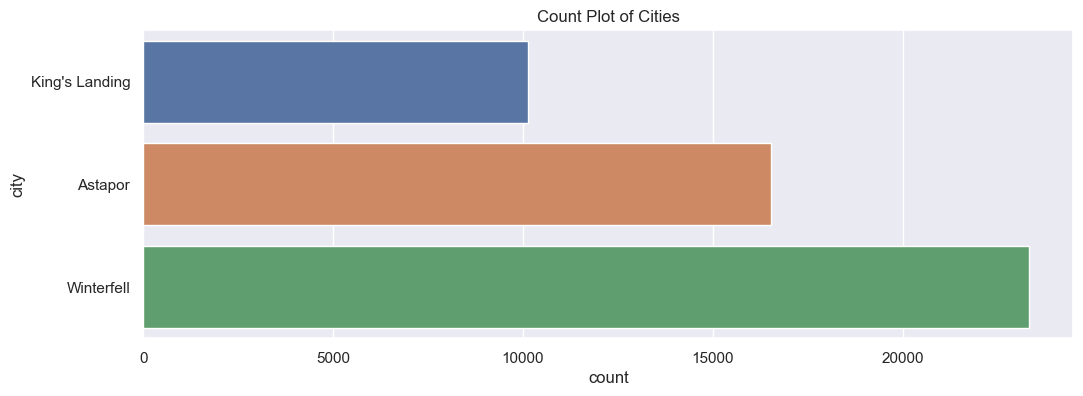

In [49]:
# a count plot of the cities
plt.figure(figsize = (12,4))
plt.title('Count Plot of Cities')
sns.countplot(y = 'city', data = df);

___

### 2.2 Trips in the First 30 Days

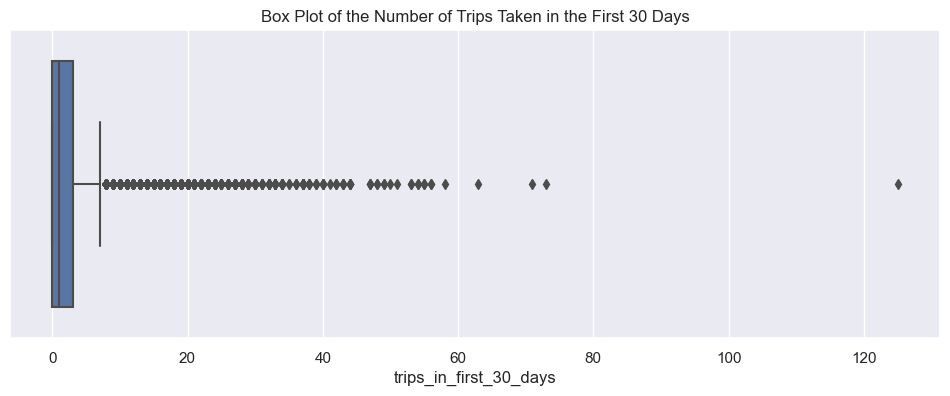

In [51]:
plt.figure(figsize = (12,4))
plt.title('Box Plot of the Number of Trips Taken in the First 30 Days')
sns.boxplot(x = 'trips_in_first_30_days', data = df);

The is one outlier with over 120 trips in the first 30 days. Let's look deeper into it:

In [53]:
# pulling the user with the highest number of rides in the first 30 days
df[df['trips_in_first_30_days']>100].T

,18514
city,King's Landing
trips_in_first_30_days,125
signup_date,2014-01-02 00:00:00
avg_rating_of_driver,5.0
avg_surge,1.12
last_trip_date,2014-06-30 00:00:00
phone,iPhone
surge_pct,14.4
ultimate_black_user,True
weekday_pct,72.0


We can see that the average distance traveled is about 2 miles per trip for this user. Even though the number of trips is high, this could be because this user uses the app to travel numerous times a day but over short distances. Let's check the average distance for all users to see if this theory tracks:

In [55]:
# average distance traveled/trip for all users
df['avg_dist'].mean()

5.7968266

It seems that our assumption about short distances is true. This user's average distance is almost 1/3 of the average distance traveled for all users.
___

### 2.3 Signup Date

For the signup date column we only need to check if all users signed up in January:

In [57]:
len(df[df['signup_date'].dt.month == 1])

50000

All our users in this dataset signed up in January, great!
___

### 2.4 Average Rating of Driver

C:\Users\ak5du\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


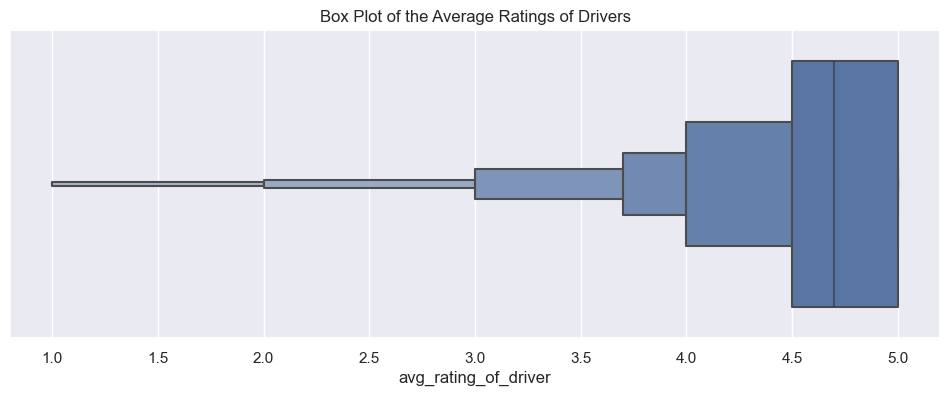

In [59]:
plt.figure(figsize = (12,4))
plt.title('Box Plot of the Average Ratings of Drivers')
sns.boxenplot(x = 'avg_rating_of_driver', data = df);

The distribution of average ratings of drivers is skewed to the right, which is good news. But, let's look into the ratings that are below 3 stars:

In [61]:
# let's see how the drivers rated the users that rated them below 3 stars, did both parties leave unhappy
df[df['avg_rating_of_driver']<3]['avg_rating_by_driver'].mean()

4.58092049296374

It doesn't seem so.</br>
___

### 2.5 Average Surge

C:\Users\ak5du\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


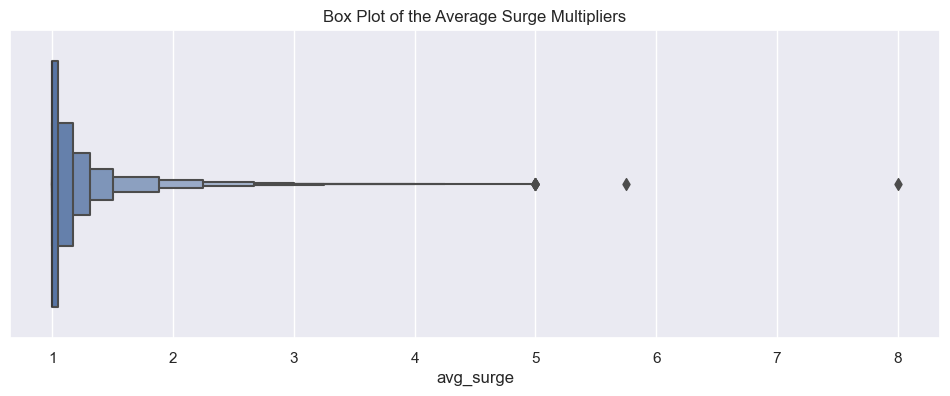

In [63]:
plt.figure(figsize = (12,4))
plt.title('Box Plot of the Average Surge Multipliers')
sns.boxenplot(x = 'avg_surge', data = df);

___

### 2.6 Active Users

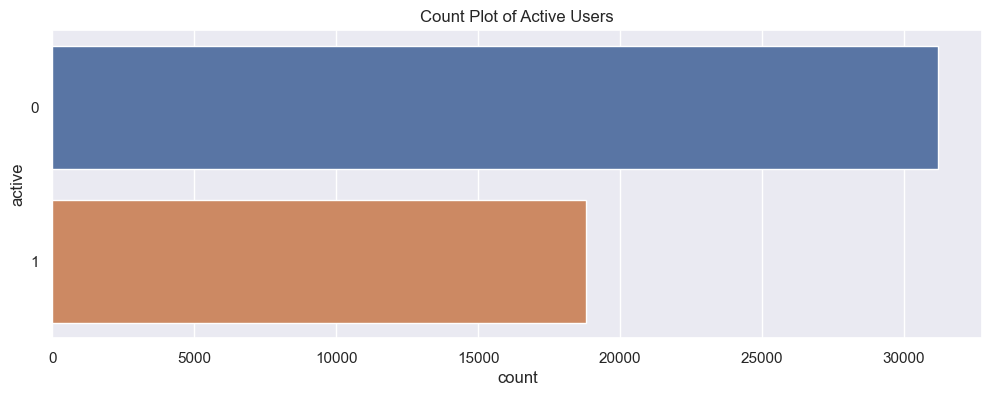

In [65]:
plt.figure(figsize = (12,4))
plt.title('Count Plot of Active Users')
sns.countplot(y = df['active'], data = df);

In [66]:
# number of active and inactive users
print(f'There are {len(df[df["active"]== 1])} active users and {len(df[df["active"]== 0])}inactive users')

There are 18804 active users and 31196inactive users


In [67]:
# calculate proportion of users that are active vs inactive 

active = len(df[df['active'] == 1]) / len(df) * 100
inactive = len(df[df['active'] == 0]) / len(df) * 100

print(f'{round(active, 2)} % of all users are active')
print(f'{round(inactive, 2)} % of all users are inactive')

37.61 % of all users are active
62.39 % of all users are inactive


___

### 2.7 Correlation between Features

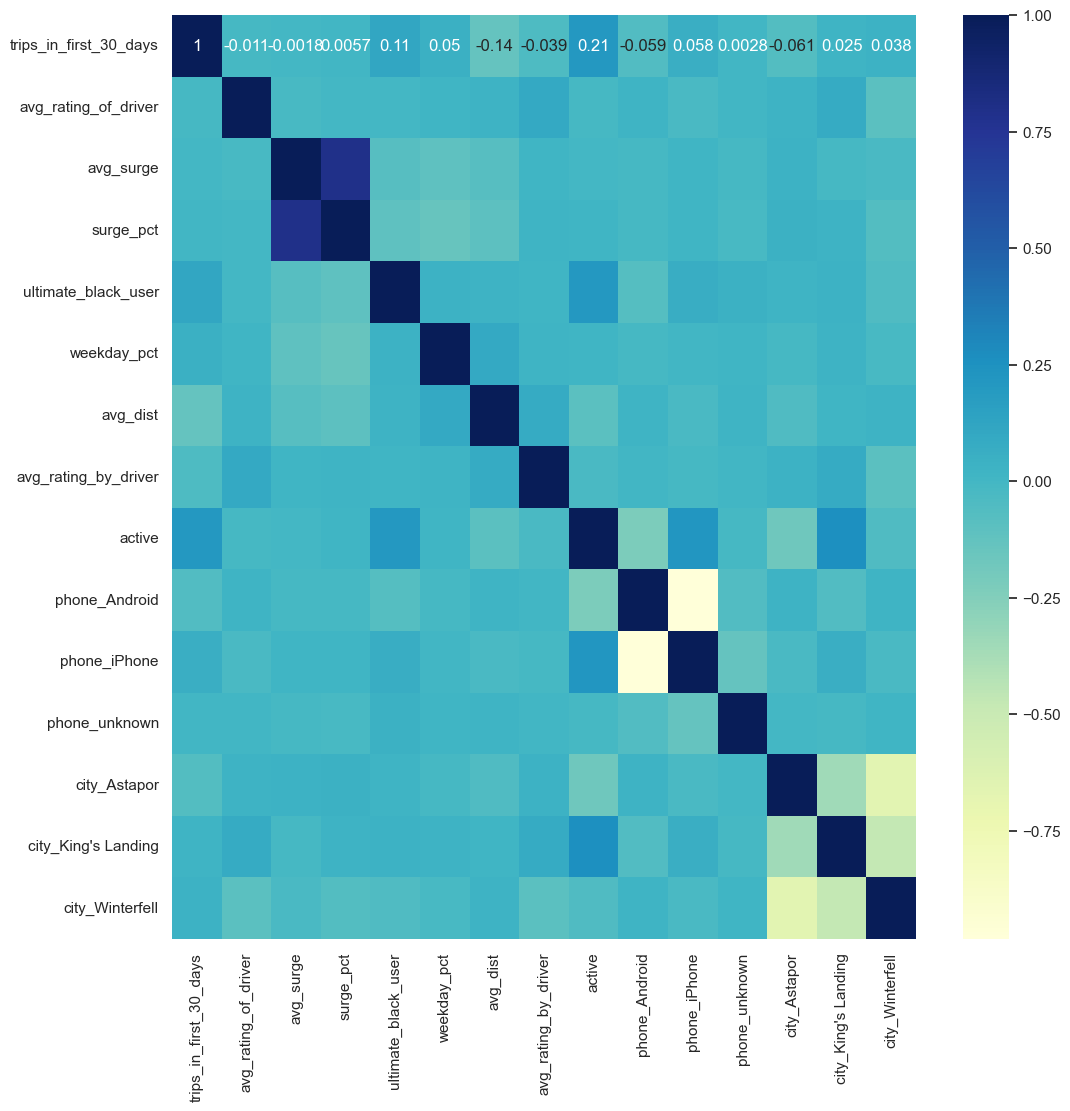

In [69]:
# heatmap showing correlations between features
plt.figure(figsize=(12,12))
dataplot = sns.heatmap(df_dummies.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()


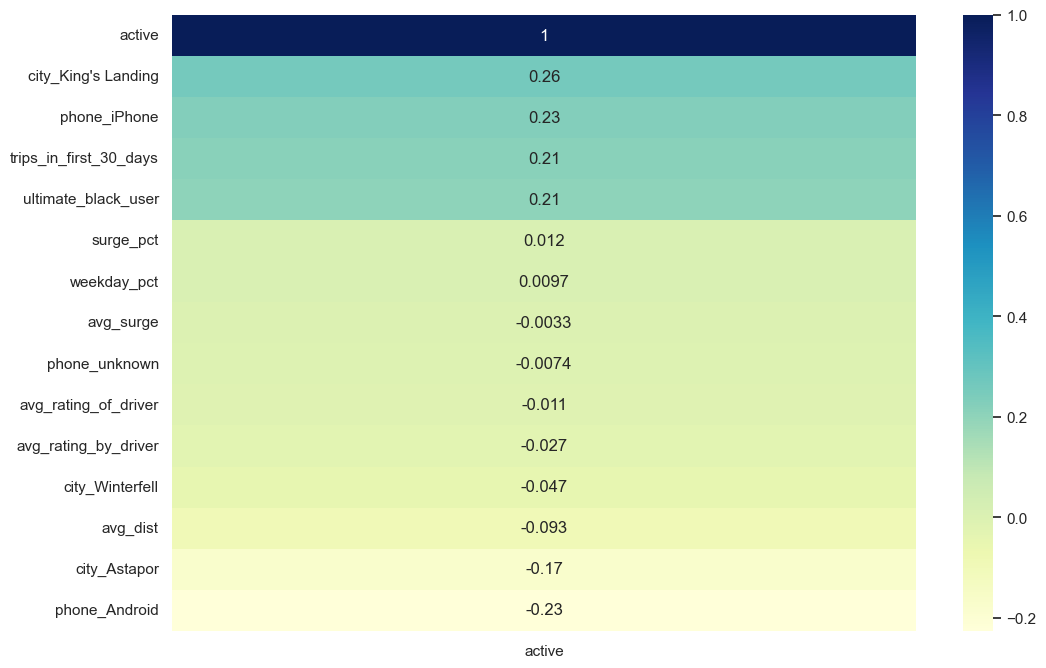

In [70]:
plt.figure(figsize=(12,8))
sns.heatmap(df_dummies.corr(numeric_only=True)[['active']].sort_values(by ='active',ascending = False),cmap="YlGnBu", annot=True)
plt.show()

We are interested in the 'active' status of a user, from this heat map we can see which features correlate highly with the 'active' status of a user.</br>
</br>
<b>Positively correlate with the 'active' status</b> are the number of trips in the first 30 day, if the the user is an ultimate black user, if the user uses an iphone, and if the user lives in King's Landing.</br>
</br>
<b>Negatively correlated with the 'active' status</b> are if the user uses an android phone, and if they live in Astapor.

___

## 3 Preprocessing

In [73]:
# dropping date columns because they won't be used in our models 
df_d_n = df_dummies.drop(['signup_date','last_trip_date'], axis = 1)
df_d_n.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,phone_Android,phone_iPhone,phone_unknown,city_Astapor,city_King's Landing,city_Winterfell
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1,0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,0,1,0,1,0,0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1,0
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,1,0,0,0,0,1


In [74]:
df_d_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int64  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   active                  50000 non-null  int64  
 9   phone_Android           50000 non-null  int32  
 10  phone_iPhone            50000 non-null  int32  
 11  phone_unknown           50000 non-null  int32  
 12  city_Astapor            50000 non-null  int32  
 13  city_King's Landing     50000 non-null  int32  
 14  city_Winterfell         50000 non-null

In [75]:
# splitting our data into y (target variable) and X (predictive variables) 

X = df_d_n.drop(['active'], axis=1)
y = df_d_n.active

In [76]:
# performing a train/test split with the testing size being 20% of total size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [77]:
# scaling features
scaler = StandardScaler()

In [78]:
scaler.fit(X_train)

StandardScaler()

In [79]:
X_train_scaled = scaler.transform(X_train)

In [80]:
X_test_scaled = scaler.transform(X_test)

___

## 4 Modeling

### 4.1 Logistic Regression


In [82]:
# instantiate model
lr = LogisticRegression()

In [83]:
# set up parameters to search and compare
param_grid = {"C" : [0.001, 0.01, 0.1, 0.5, 1, 1.5, 3, 5, 7, 10, 50],
             "penalty" : ['l2'], 
             "solver" : ['lbfgs', 'newton-cg'], 
             "class_weight": [None, 'balanced']}

# create grid search - cross-validation object 
gs_final = GridSearchCV(estimator = lr, param_grid=param_grid, cv=10, n_jobs=-1, scoring='accuracy')

# fit training data
gs_final.fit(X_train_scaled,y_train)
print("best parameters: ",gs_final.best_params_)

best parameters:  {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


In [84]:
# predict class for X
y_pred = gs_final.best_estimator_.predict(X_test_scaled)


# create function that prints evaluation scores
def evaluate(y__test, y__pred):
    ac = accuracy_score(y__test, y__pred)
    f1 = f1_score(y__test, y__pred, average='weighted')
    pr = precision_score(y__test, y__pred, average='macro')
    re = recall_score(y__test, y__pred, average='macro')

    print('Accuracy Score = %.3f' % (ac))
    print('F1 Score = %.3f' % (f1))
    print("Precision = {}".format(round(pr, 3)))
    print("Recall = {}".format(round(re, 3)))


# generate accuracy and f1 scores
evaluate(y_test, y_pred)

Accuracy Score = 0.714
F1 Score = 0.702
Precision = 0.7
Recall = 0.668


We achieved an accuracy score of 70% which isn't too bad. Let's take a look at the coefficients to see which features are most predictive of our target variable.

In [86]:
# access and rank the coefficients for our independent variables 

steps = gs_final.best_estimator_
df_coef = pd.DataFrame(zip(list(df_d_n.columns[:-1]),steps.coef_[0]),index=range(df_d_n.columns[:-1].shape[0]),columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)

,feature,coefficient
12,city_Astapor,0.385754
0,trips_in_first_30_days,0.385471
4,ultimate_black_user,0.371701
9,phone_Android,0.229104
3,surge_pct,0.060973
10,phone_iPhone,-0.001402
5,weekday_pct,-0.002206
2,avg_surge,-0.020393
1,avg_rating_of_driver,-0.026086
13,city_King's Landing,-0.053951


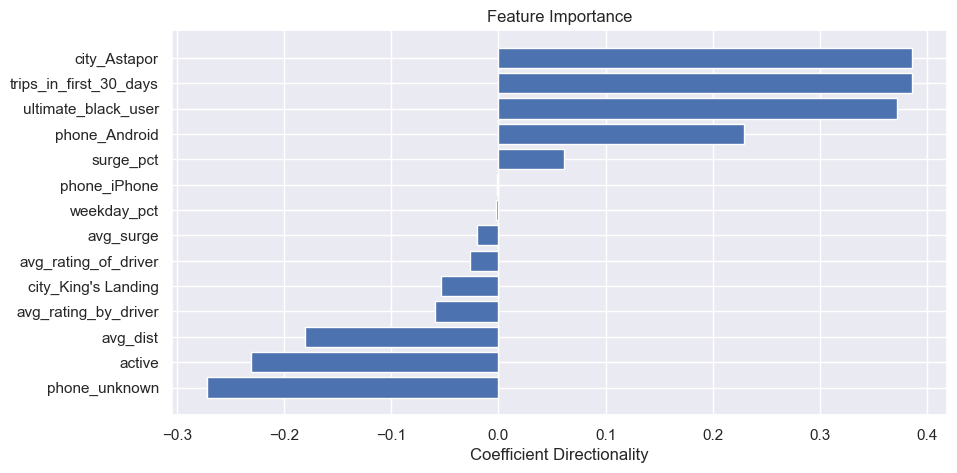

In [87]:
# plot feature importance scores(coefficients), ordered by importance

scores_ = np.array(steps.coef_[0])
sorted_idx = np.argsort(scores_)

# make plots 
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(10,5))
plt.barh(pos, scores_[sorted_idx], align='center')
plt.yticks(pos, df_d_n.columns[sorted_idx])
plt.xlabel('Coefficient Directionality')
plt.title('Feature Importance')
plt.show()

### 4.2 Random Forrest Classifier

In [89]:
# instantiating a random forrest model
rf = RandomForestClassifier()

In [ ]:
# Hyperparameter tuning with Grid Search

params = {'bootstrap': [True, False],
        'max_depth': [10, 15, 20, 25],
        'max_features': ['sqrt'],
        'min_samples_leaf': [3, 5, 7, 9],
        'min_samples_split': [1, 2, 5, 10],
        'n_estimators': [25, 50, 75, 100]}

rf_gscv = GridSearchCV(estimator = rf, param_grid=params, cv=5, verbose=True, n_jobs=-1, scoring='accuracy')

rf_gscv.fit(X_train_scaled, y_train)

print("best parameters: ",rf_gscv.best_params_)
print(f'Training accuracy score from tuned model: {rf_gscv.best_score_*100:.1f}%')

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


In [91]:
# evaluate predictions from Grid Search tuning 

# predict class for X
y_pred = rf_gscv.predict(X_test_scaled)

# generate accuracy and f1 scores
evaluate(y_test, y_pred)

Accuracy Score = 0.783
F1 Score = 0.780
Precision = 0.773
Recall = 0.759


The Ranodm Forrest Classifier model has an accuracy of 78% which outperforms the Logistic Regression model.

In [93]:
rf_gscv.best_estimator_.feature_importances_

array([0.06713112, 0.04287049, 0.09535103, 0.11828867, 0.05761554,
       0.13218483, 0.09285106, 0.16194651, 0.04487453, 0.03808055,
       0.00034992, 0.03710389, 0.09218892, 0.01916293])

In [94]:
d = {'Feature':X.columns, 'Feature Importance':rf_gscv.best_estimator_.feature_importances_ }
feature_importance_df = pd.DataFrame(d)
feature_importance_df

,Feature,Feature Importance
0,trips_in_first_30_days,0.067131
1,avg_rating_of_driver,0.042870
2,avg_surge,0.095351
3,surge_pct,0.118289
4,ultimate_black_user,0.057616
5,weekday_pct,0.132185
6,avg_dist,0.092851
7,avg_rating_by_driver,0.161947
8,phone_Android,0.044875
9,phone_iPhone,0.038081


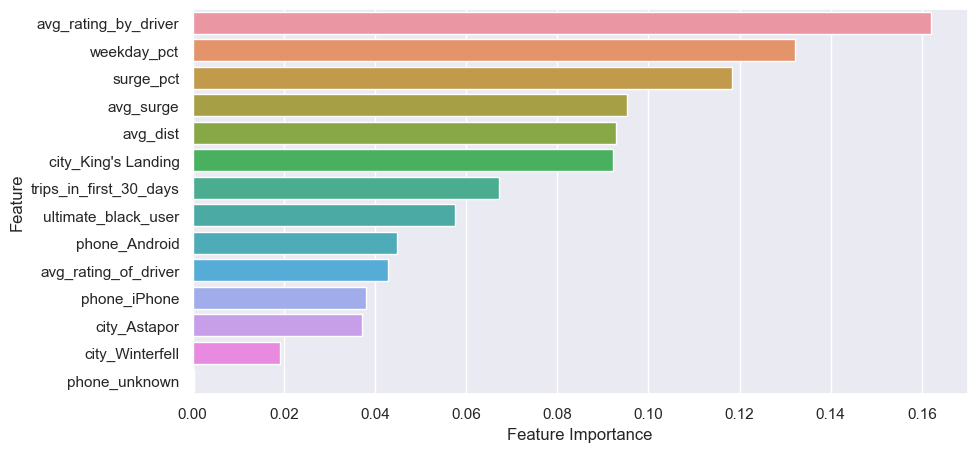

In [95]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'Feature Importance', y = 'Feature', data = feature_importance_df.sort_values(by ='Feature Importance', ascending=False));

___ 

## 5 Conclusion

The Random Forest Classifier produced the better results, with accuracy equal to 78%. <b> Some notes on some of the features:</b></br>
</br>
<b>King's Landing:</b> Users from King's Landing were the most likely to be retained out of the three cities. This correlation should invite further investigation into why that is. Are the residents of King's Landing more likely to be retained because of an initiative the company is taking? An advertising campaign for example? If so, we should consider applying similar measures to the other two cities. Are they more likely to be retained because of geographical/ demographical reasons which are inherent to the city? If so, we should make sure we are not undervaluing our business in that city.</br>
</br>
<b>iPhone users:</b> iPhone users are more likely to be retained than Android users. As a matter of fact, Android is negatively correlated with being retained. This might be due to an underlying demographic difference between the two user categories.</br>
</br>

___